# Kalman Filter: From Model to Real-Time Tracking & Accuracy Analysis

#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025


# Part I: Constructing the Kalman Filter: From Model to Real-Time Tracking

### 1 - 2. Generate True Trajectory and Measurements

Define the simulation parameters. Generate the true trajectory of a drifting raft over 200 time steps. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 200
T = 1.0
x1 = 5.0
V1 = 1.0
sigma_a_sq = 0.2**2
sigma_a = np.sqrt(sigma_a_sq)
sigma_eta_sq = 20**2
sigma_eta = np.sqrt(sigma_eta_sq)
m = 7 

def generate_trajectory_and_measurements(N, x1, V1, T, sigma_a, sigma_eta):
    x_true = np.zeros(N)
    V_true = np.zeros(N)
    x_true[0] = x1
    V_true[0] = V1
    
    for i in range(1, N):
        a = np.random.normal(0, sigma_a)
        x_true[i] = x_true[i-1] + V_true[i-1] * T + (a * T**2) / 2
        V_true[i] = V_true[i-1] + a * T
        
    eta = np.random.normal(0, sigma_eta, N)
    z = x_true + eta
    return x_true, V_true, z

### 3. & 4. State-Space Model and Kalman Filter Algorithm

Here, we define the components of the state-space model and implement the Kalman filter algorithm. The filter iterates through each time step, performing prediction and filtration (update) to estimate the system's state.

In [ ]:
def run_kalman_filter(z, N, T, sigma_a_sq, sigma_eta_sq, X0_0, P0_0, m_steps, Q_override=None):
    Phi = np.array([[1, T], [0, 1]])
    G = np.array([[T**2 / 2], [T]])
    H = np.array([[1, 0]])
    R = np.array([[sigma_eta_sq]])
    I = np.eye(2)

    if Q_override is not None:
        Q = Q_override
    else:
        Q = G @ G.T * sigma_a_sq

    X_filt_prev = X0_0
    P_filt_prev = P0_0

    X_predicted = np.zeros((N, 2, 1))
    P_predicted = np.zeros((N, 2, 2))
    X_filtered = np.zeros((N, 2, 1))
    P_filtered = np.zeros((N, 2, 2))
    K_history = np.zeros((N, 2, 1))
    x_predicted_ahead = np.full(N, np.nan)

    prediction_steps = m_steps - 1
    Phi_m_minus_1 = np.linalg.matrix_power(Phi, prediction_steps)

    for i in range(N):
        X_pred = Phi @ X_filt_prev
        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        residual = z[i] - H @ X_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        X_filt = X_pred + K @ residual
        P_filt = (I - K @ H) @ P_pred

        X_predicted[i], P_predicted[i] = X_pred, P_pred
        X_filtered[i], P_filtered[i] = X_filt, P_filt
        K_history[i] = K

        if i + prediction_steps < N:
            X_pred_at_future_step = Phi_m_minus_1 @ X_filt
            x_predicted_ahead[i + prediction_steps] = X_pred_at_future_step[0, 0]
            
        X_filt_prev, P_filt_prev = X_filt, P_filt
        
    return X_filtered, P_filtered, X_predicted, P_predicted, K_history, x_predicted_ahead


### 5. Plotting the Results

Visualize the outcome of a single Kalman filter run, showing the true trajectory, noisy measurements, and the much smoother filtered estimate.

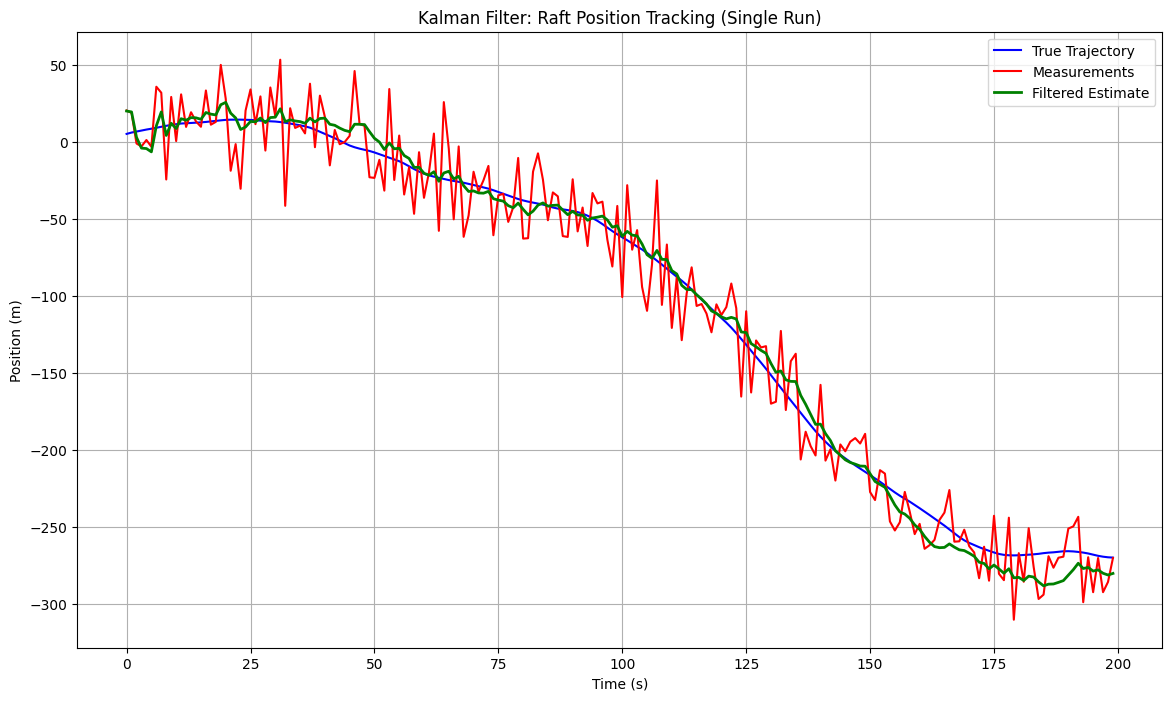

In [66]:
# for i in range (3):
x_true, V_true, z = generate_trajectory_and_measurements(N, x1, V1, T, sigma_a, sigma_eta)

X0_0_orig = np.array([[2.0], [0.0]])
P0_0_orig = np.array([[10000, 0], [0, 10000]])

X_filtered, P_filtered, X_predicted, P_predicted, K_history, x_predicted_ahead = run_kalman_filter(z, N, T, sigma_a_sq, sigma_eta_sq, X0_0_orig, P0_0_orig, m)

x_filtered_estimates = X_filtered[:, 0, 0]
time = np.arange(N) * T

plt.figure(figsize=(14, 8))
plt.plot(time, x_true, 'b-', label='True Trajectory')
plt.plot(time, z, 'r', markersize=4, label='Measurements')
plt.plot(time, x_filtered_estimates, 'g-', linewidth=2, label='Filtered Estimate')
plt.title('Kalman Filter: Raft Position Tracking (Single Run)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

### 6. Analysis of Filter Gain and Estimation Errors

We analyze the filter's internal parameters. The plots show that both the filter gain `K` and the filter's calculated standard deviation `σx` quickly converge to a steady state. This demonstrates that their values are independent of the specific measurements and depend only on the model's statistical properties.

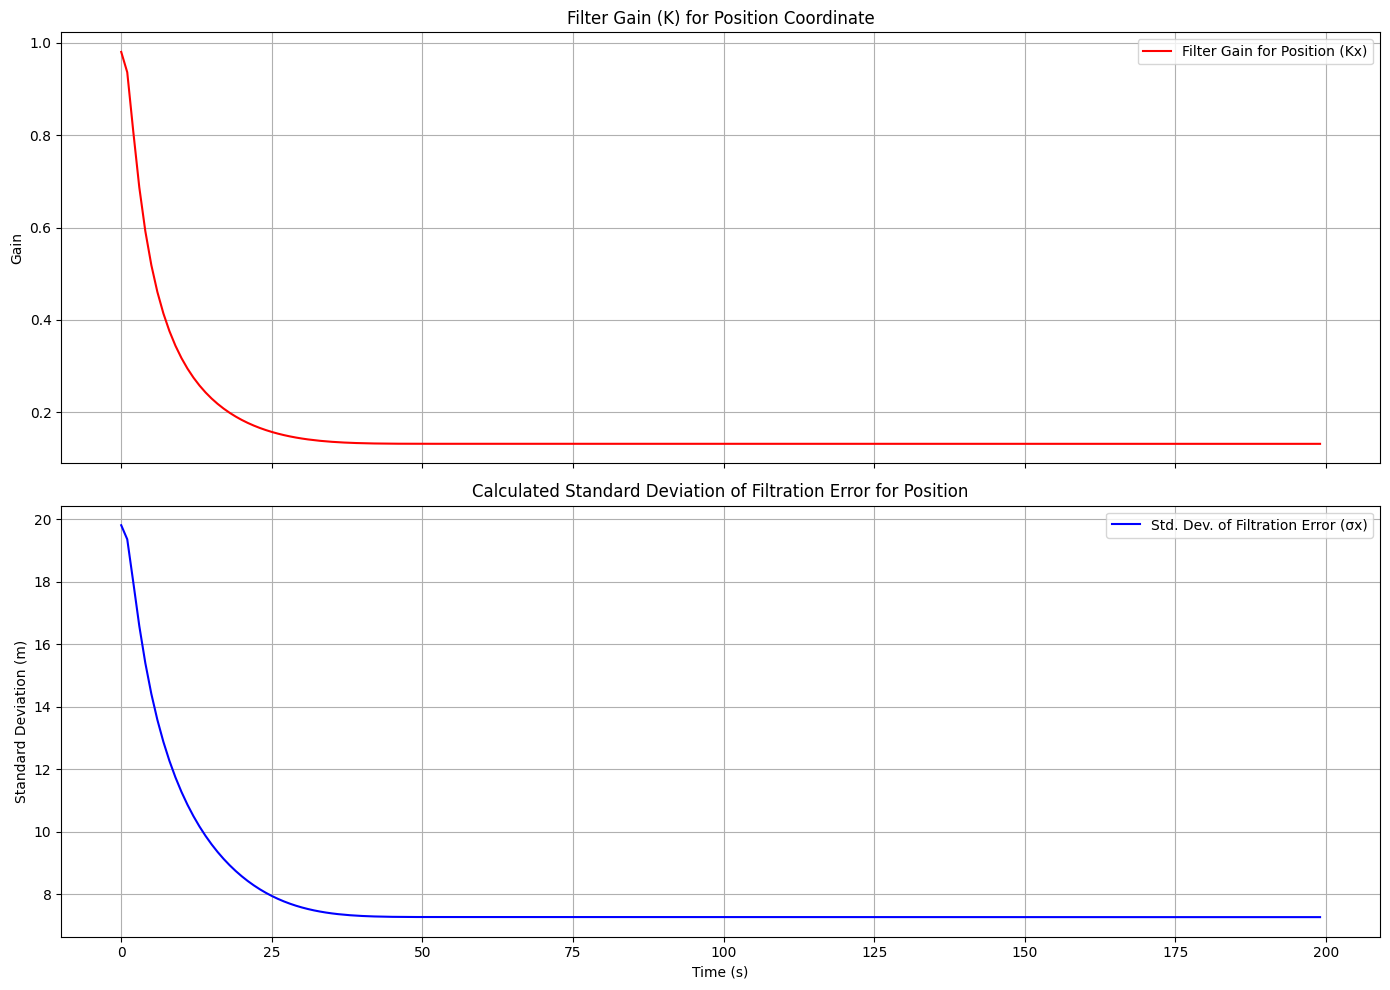

In [69]:
k_gain_position = K_history[:, 0, 0]
sigma_x_filtered = np.sqrt(P_filtered[:, 0, 0])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(time, k_gain_position, 'r-', label='Filter Gain for Position (Kx)')
ax1.set_title('Filter Gain (K) for Position Coordinate')
ax1.set_ylabel('Gain')
ax1.legend()
ax1.grid(True)

ax2.plot(time, sigma_x_filtered, 'b-', label='Std. Dev. of Filtration Error (σx)')
ax2.set_title('Calculated Standard Deviation of Filtration Error for Position')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Standard Deviation (m)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 7. Predictions of Future States

Using the filtered estimate at each time step `i`, we predict the raft's position `m-1=6` steps into the future. The plot shows these predictions against the true trajectory.

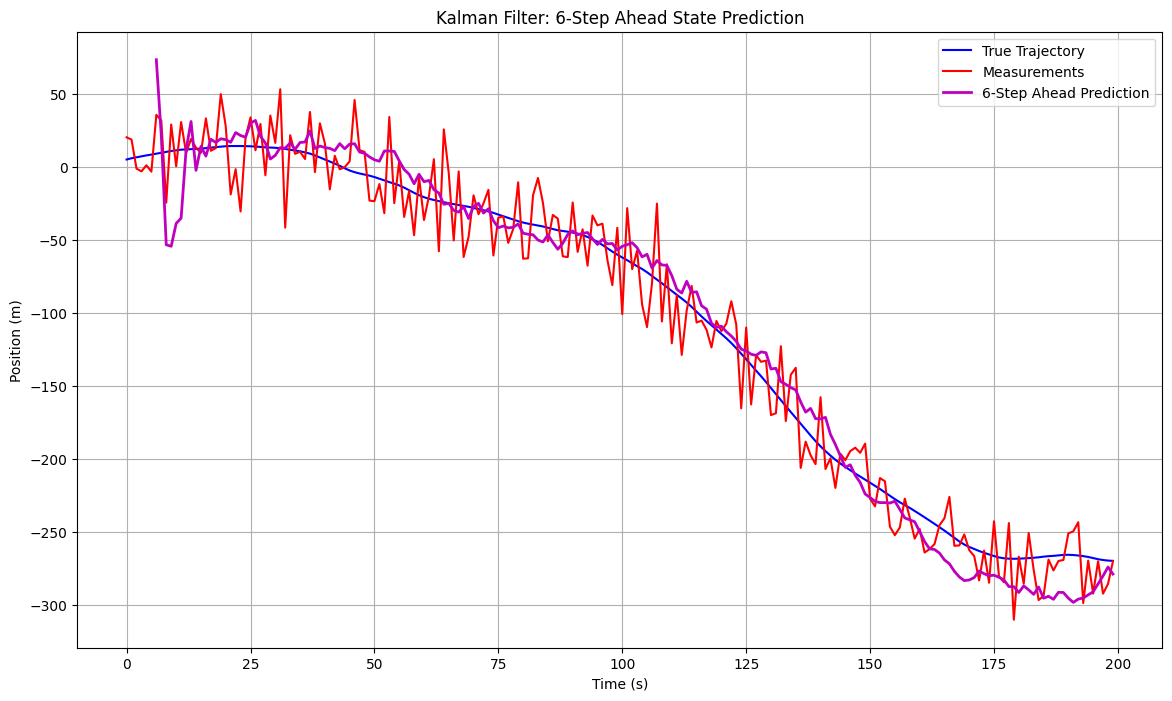

In [74]:
plt.figure(figsize=(14, 8))
plt.plot(time, x_true, 'b-', label='True Trajectory')
plt.plot(time, z, 'r-', markersize=4, label='Measurements')
plt.plot(time, x_predicted_ahead, 'm-', linewidth=2, label=f'{m-1}-Step Ahead Prediction')
plt.title(f'Kalman Filter: {m-1}-Step Ahead State Prediction')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

# Part II: Accuracy Analysis Under Optimal and Non-Optimal Conditions

### 1 - 2. Statistical Estimation Errors & Comparison with Measurement Noise

To properly assess the filter's performance, we conduct a Monte Carlo simulation with M=500 runs. For each run, we generate a new trajectory and measurement set. We then calculate the Root Mean Squared Error (RMSE) for three different estimates: the filtered estimate, the 1-step ahead prediction, and the 6-step ahead prediction. The plot shows these true statistical errors over time.

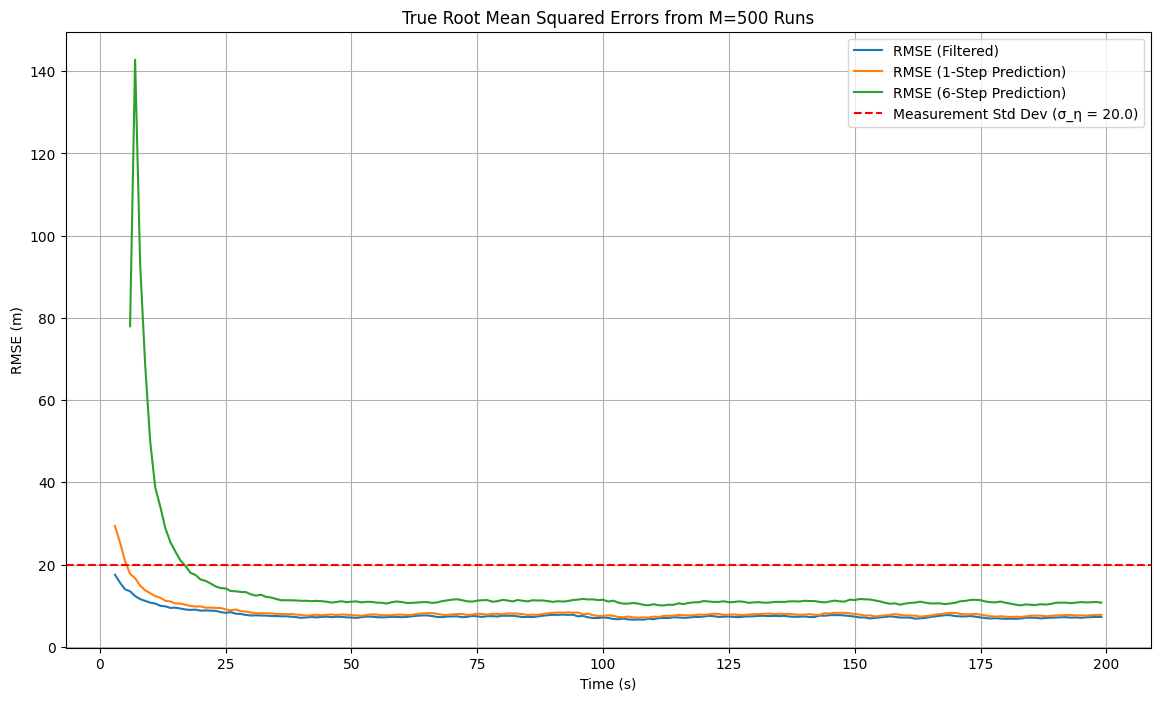

Standard deviation of measurement noise: 20.00 m
Steady-state RMSE of filtered estimate: 7.26 m
The filter reduces the error by a factor of 2.76.


In [ ]:
def monte_carlo_simulation(M, N, T, sigma_a, sigma_eta, X0_0, P0_0, m_steps, Q_override=None, fixed_K=None):
    error_filt_sq = np.zeros((M, N))
    error_pred_1_sq = np.zeros((M, N))
    error_pred_m_sq = np.zeros((M, N))

    for r in range(M):
        x_true, _, z = generate_trajectory_and_measurements(N, x1, V1, T, sigma_a, sigma_eta)
        
        if fixed_K is not None:
             # This part is for a later section, running with a fixed gain
            X_filt_prev = X0_0
            x_filtered_run = np.zeros(N)
            for i in range(N):
                X_pred = np.array([[1, T], [0, 1]]) @ X_filt_prev
                residual = z[i] - np.array([[1,0]]) @ X_pred
                X_filt = X_pred + fixed_K @ residual
                x_filtered_run[i] = X_filt[0,0]
                X_filt_prev = X_filt
            error_filt_sq[r, :] = (x_true - x_filtered_run)**2
        else:
            res = run_kalman_filter(z, N, T, sigma_a**2, sigma_eta**2, X0_0, P0_0, m_steps, Q_override)
            X_filtered, _, X_predicted, _, _, x_predicted_ahead = res

            error_filt_sq[r, :] = (x_true - X_filtered[:, 0, 0])**2
            error_pred_1_sq[r, :] = (x_true - X_predicted[:, 0, 0])**2
            error_pred_m_sq[r, :] = (x_true - x_predicted_ahead)**2

    # Calculate final RMSE, starting from index 3
    rmse_filt = np.sqrt(np.mean(error_filt_sq[:, 3:], axis=0))
    rmse_pred_1 = np.sqrt(np.mean(error_pred_1_sq[:, 3:], axis=0))
    rmse_pred_m = np.sqrt(np.mean(error_pred_m_sq[:, 3:], axis=0))
    
    return rmse_filt, rmse_pred_1, rmse_pred_m

M = 500
rmse_filt_orig, rmse_pred_1_orig, rmse_pred_m_orig = monte_carlo_simulation(M, N, T, sigma_a, sigma_eta, X0_0_orig, P0_0_orig, m)

time_from_3 = np.arange(3, N) * T
plt.figure(figsize=(14, 8))
plt.plot(time_from_3, rmse_filt_orig, label='RMSE (Filtered)')
plt.plot(time_from_3, rmse_pred_1_orig, label='RMSE (1-Step Prediction)')
plt.plot(time_from_3, rmse_pred_m_orig, label=f'RMSE ({m-1}-Step Prediction)')
plt.axhline(y=sigma_eta, color='r', linestyle='--', label=f'Measurement Std Dev (σ_η = {sigma_eta})')
plt.title('True Root Mean Squared Errors from M=500 Runs')
plt.xlabel('Time (s)')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)
plt.show()

steady_state_error = rmse_filt_orig[-1]
print(f"Standard deviation of measurement noise: {sigma_eta:.2f} m")
print(f"Steady-state RMSE of filtered estimate: {steady_state_error:.2f} m")
print(f"The filter reduces the error by a factor of {sigma_eta/steady_state_error:.2f}")

### 3. Impact of Initial Filtration Error Covariance `P0,0`

We repeat the Monte Carlo simulation with a more accurate (smaller) initial error covariance matrix `P0,0`. The plot compares the RMSE from this new simulation with the original one. It shows that while a better initial guess leads to faster convergence, the filter eventually reaches the same steady-state error regardless of the initial conditions, demonstrating its robustness.

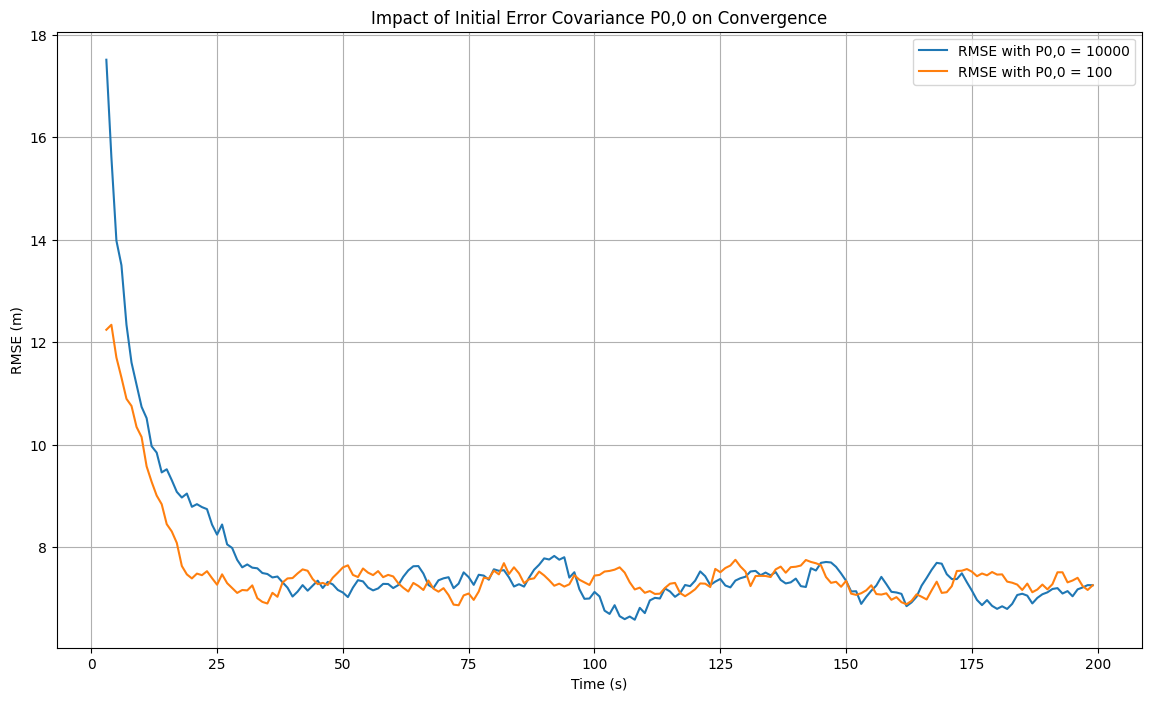

In [41]:
P0_0_accurate = np.array([[100, 0], [0, 100]])
rmse_filt_acc, _, _ = monte_carlo_simulation(M, N, T, sigma_a, sigma_eta, X0_0_orig, P0_0_accurate, m)

plt.figure(figsize=(14, 8))
plt.plot(time_from_3, rmse_filt_orig, label='RMSE with P0,0 = 10000')
plt.plot(time_from_3, rmse_filt_acc, label='RMSE with P0,0 = 100')
plt.title('Impact of Initial Error Covariance P0,0 on Convergence')
plt.xlabel('Time (s)')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)
plt.show()

### 4. Comparison of Calculated and True Estimation Errors

Here, we compare the filter's self-reported accuracy (the *calculated* error, `σx`) with the *true* statistical error (RMSE from 500 runs). The plots for both filtration and prediction show that the calculated and true errors match almost perfectly. This is a critical result: it means that when the model is correct, the Kalman filter provides not only an optimal estimate but also a reliable and accurate measure of its own uncertainty, which is invaluable for practical applications.

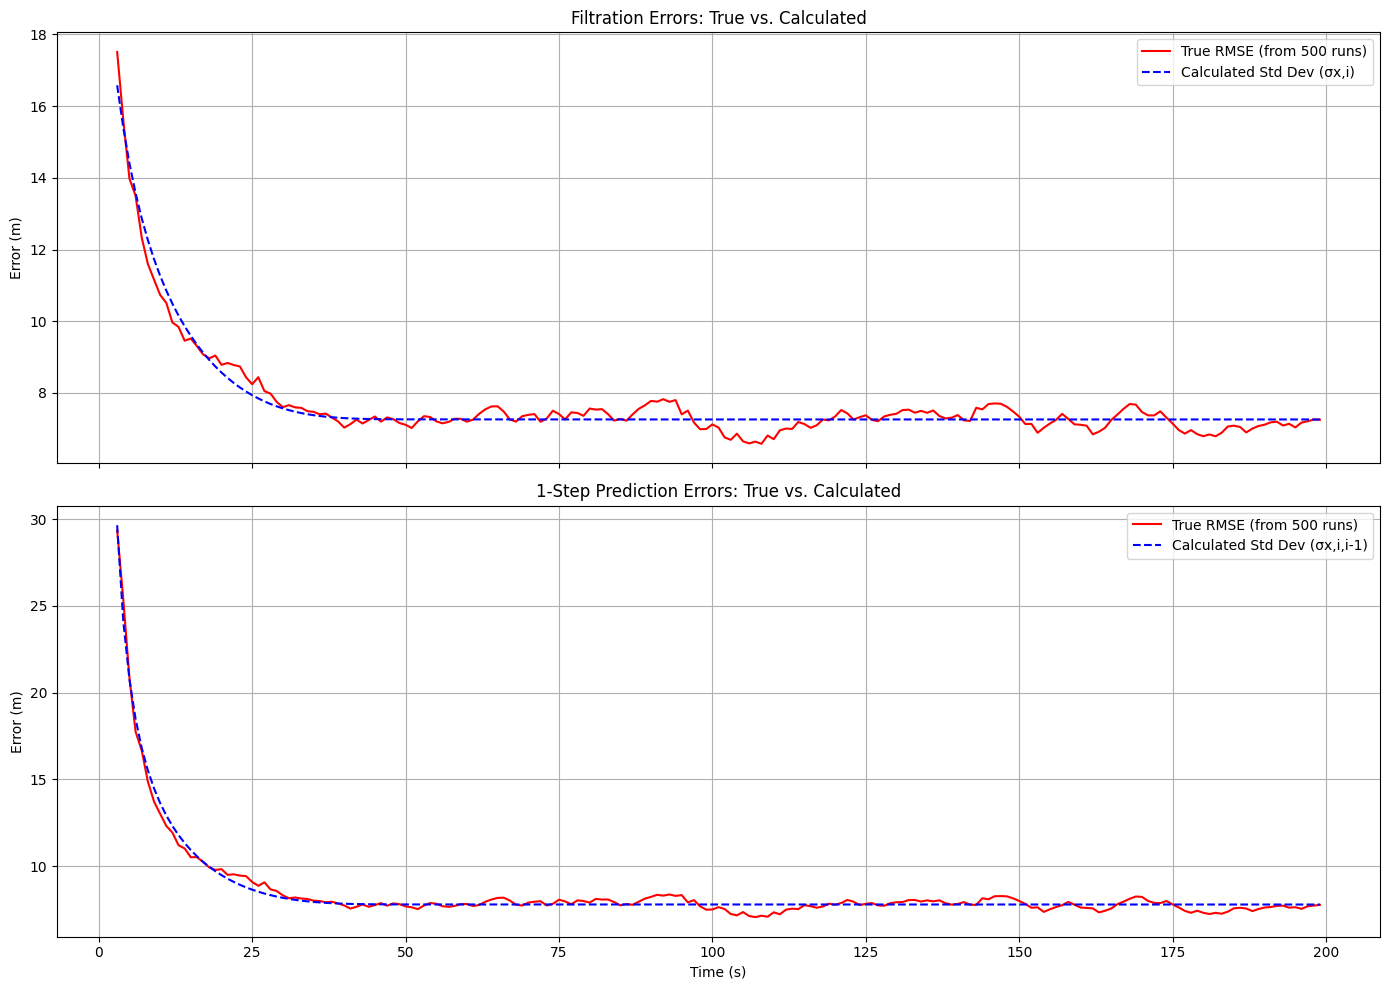

In [42]:
sigma_x_filt_calc = np.sqrt(P_filtered[:, 0, 0])
sigma_x_pred_calc = np.sqrt(P_predicted[:, 0, 0])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(time_from_3, rmse_filt_orig, 'r-', label='True RMSE (from 500 runs)')
ax1.plot(time_from_3, sigma_x_filt_calc[3:], 'b--', label='Calculated Std Dev (σx,i)')
ax1.set_title('Filtration Errors: True vs. Calculated')
ax1.set_ylabel('Error (m)')
ax1.legend()
ax1.grid(True)

ax2.plot(time_from_3, rmse_pred_1_orig, 'r-', label='True RMSE (from 500 runs)')
ax2.plot(time_from_3, sigma_x_pred_calc[3:], 'b--', label='Calculated Std Dev (σx,i,i-1)')
ax2.set_title('1-Step Prediction Errors: True vs. Calculated')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Error (m)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 5. Deterministic Model (`σa^2 = 0`)

We now consider a deterministic trajectory with no random acceleration (`σa^2 = 0`). The results show that the filter gain `K` and both the true and calculated estimation errors approach zero. This is expected: without random disturbances, the model becomes perfect over time. The filter learns this and begins to trust its own predictions entirely, effectively ignoring the noisy measurements.

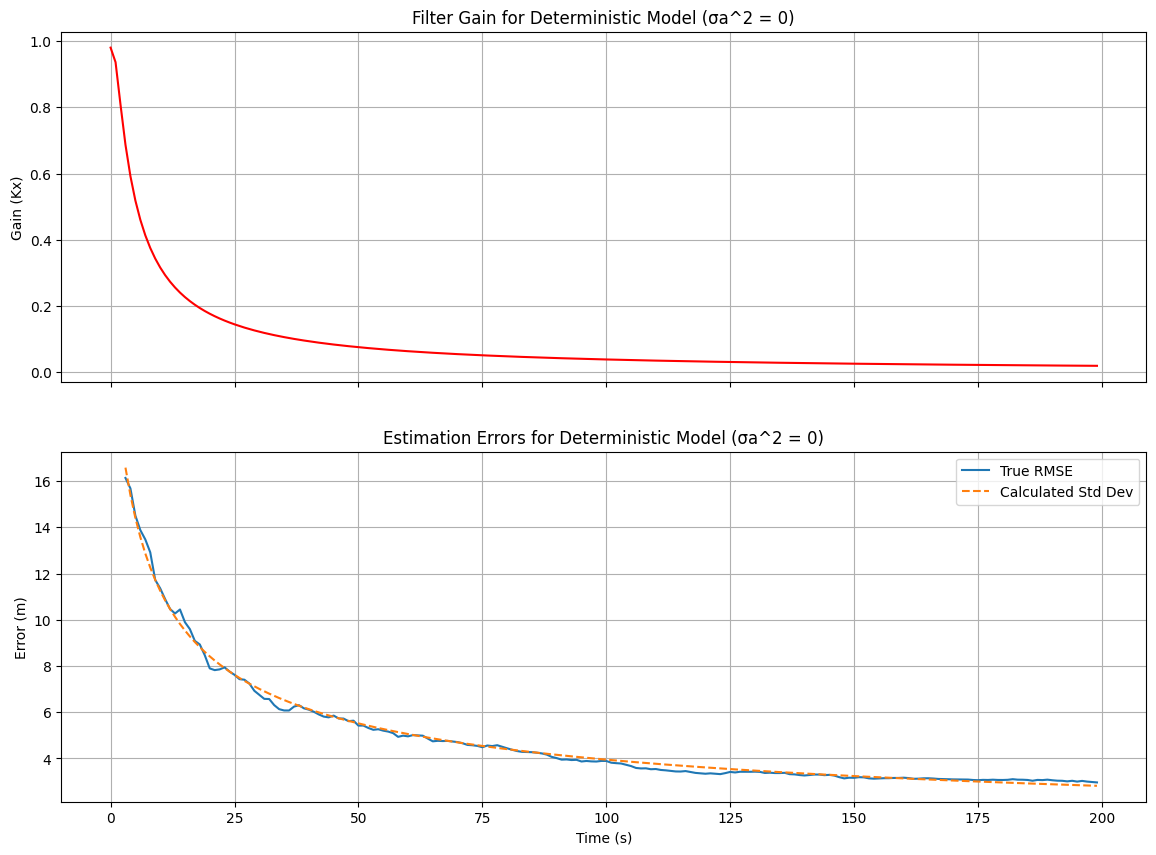

In [ ]:
# Run once to get the gain and calculated error history
_, P_filt_det, _, _, K_hist_det, _ = run_kalman_filter(z, N, T, 0, sigma_eta_sq, X0_0_orig, P0_0_orig, m)

# Run M=500 times to get the true error
rmse_filt_det, _, _ = monte_carlo_simulation(M, N, T, 0, sigma_eta, X0_0_orig, P0_0_orig, m)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(time, K_hist_det[:, 0, 0], 'r-')
ax1.set_title('Filter Gain for Deterministic Model (σa^2 = 0)')
ax1.set_ylabel('Gain (Kx)')
ax1.grid(True)

ax2.plot(time_from_3, rmse_filt_det, label='True RMSE')
ax2.plot(time_from_3, np.sqrt(P_filt_det[3:, 0, 0]), '--', label='Calculated Std Dev')
ax2.set_title('Estimation Errors for Deterministic Model (σa^2 = 0)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Error (m)')
ax2.legend()
ax2.grid(True)
plt.show()

### 6. Stochastic Model with a Filter Designed for a Deterministic Model (Q=0)

This is a critical stress test. The raft's true motion is stochastic (`σa^2 = 0.2^2`), but we tell the filter that the model is perfect by setting `Q=0`. The first plot shows that the true estimation error grows indefinitely. The filter, believing its model is perfect, stops listening to new measurements (its gain goes to zero), but the raft continues to drift randomly. The second plot is even more telling: the filter becomes completely confident in its diverging estimate (calculated error goes to zero) while the true error grows. This is known as filter divergence and highlights the danger of using a mismatched model.

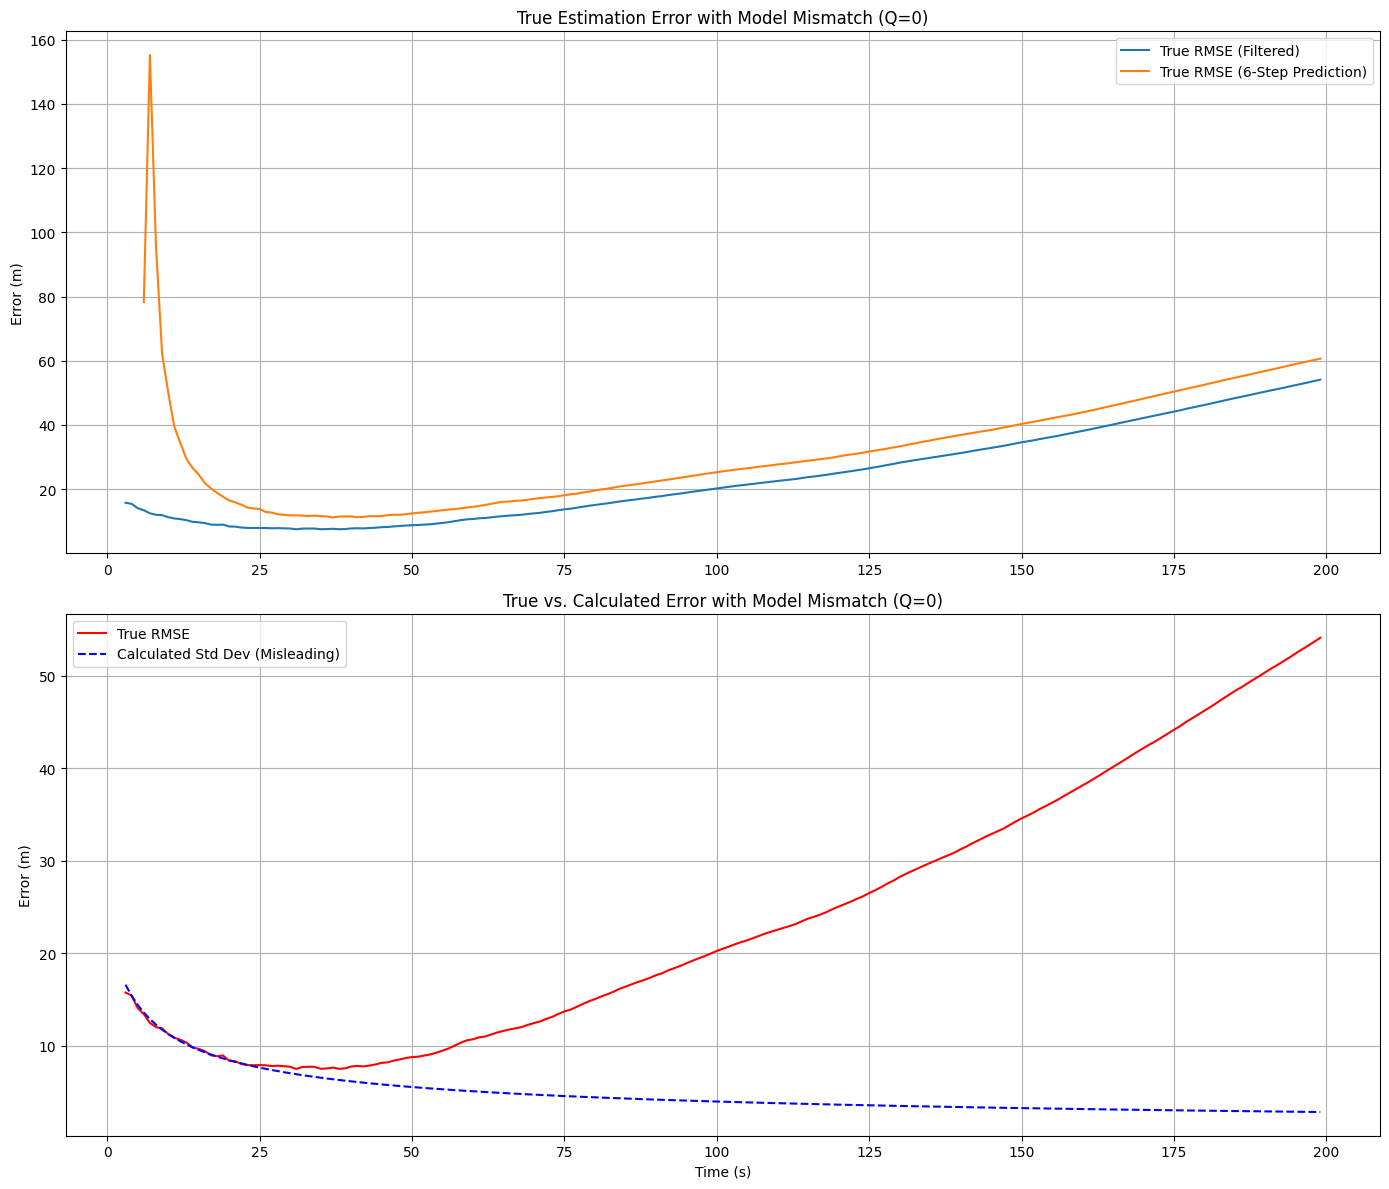

In [44]:
# Run with model mismatch: true sigma_a > 0, but Q=0 in filter
Q_mismatch = np.zeros((2,2))
rmse_filt_mm, _, rmse_pred_m_mm = monte_carlo_simulation(M, N, T, sigma_a, sigma_eta, X0_0_orig, P0_0_orig, m, Q_override=Q_mismatch)

# Get calculated error from a single mismatched run
_, P_filt_mm, _, _, _, _ = run_kalman_filter(z, N, T, sigma_a_sq, sigma_eta_sq, X0_0_orig, P0_0_orig, m, Q_override=Q_mismatch)
sigma_x_calc_mm = np.sqrt(P_filt_mm[:, 0, 0])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

ax1.plot(time_from_3, rmse_filt_mm, label='True RMSE (Filtered)')
ax1.plot(time_from_3, rmse_pred_m_mm, label=f'True RMSE ({m-1}-Step Prediction)')
ax1.set_title('True Estimation Error with Model Mismatch (Q=0)')
ax1.set_ylabel('Error (m)')
ax1.legend()
ax1.grid(True)

ax2.plot(time_from_3, rmse_filt_mm, 'r-', label='True RMSE')
ax2.plot(time_from_3, sigma_x_calc_mm[3:], 'b--', label='Calculated Std Dev (Misleading)')
ax2.set_title('True vs. Calculated Error with Model Mismatch (Q=0)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Error (m)')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

### 7. Analysis of the Relationship Between State and Measurement Noise

We investigate how the filter gain `K` changes when the state noise (`σa^2`) is increased relative to the measurement noise. We run the filter with `σa^2 = 1` and compare the gain to the original case (`σa^2 = 0.2^2`).

A larger ratio of state noise to measurement noise (`σw^2 / ση^2`) leads to a **higher** steady-state gain `K`. This is because higher state noise means the system's dynamics are more unpredictable, so the filter's predictions (`X_pred`) are less reliable. To compensate, the filter gives more weight to the incoming measurements, hence the higher gain.

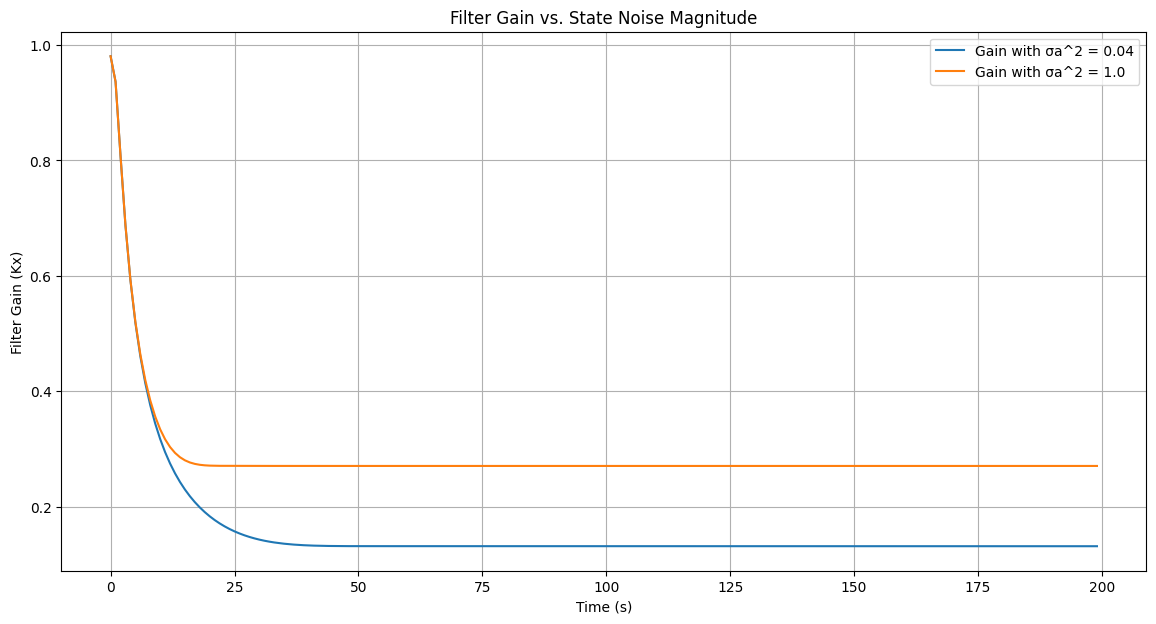

In [45]:
sigma_a_large_sq = 1.0**2

# Run once with original sigma_a
_, _, _, _, K_hist_orig, _ = run_kalman_filter(z, N, T, sigma_a_sq, sigma_eta_sq, X0_0_orig, P0_0_orig, m)

# Run once with large sigma_a
_, _, _, _, K_hist_large, _ = run_kalman_filter(z, N, T, sigma_a_large_sq, sigma_eta_sq, X0_0_orig, P0_0_orig, m)

plt.figure(figsize=(14, 7))
plt.plot(time, K_hist_orig[:, 0, 0], label='Gain with σa^2 = 0.04')
plt.plot(time, K_hist_large[:, 0, 0], label='Gain with σa^2 = 1.0')
plt.title('Filter Gain vs. State Noise Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Filter Gain (Kx)')
plt.legend()
plt.grid(True)
plt.show()

### 8. Non-optimal (Underestimated) Filter Gain

Finally, we test the filter's sensitivity to a poorly chosen, non-optimal gain. We first find the steady-state gain from the optimal filter (`K_steady_state`). Then, we run a new simulation where the gain is fixed at a much smaller value (`K_steady_state / 5`). We start with a large initial state error to make the test more challenging.

The plot clearly shows that the filter with the underestimated gain performs significantly worse. Its error converges much more slowly and to a higher steady-state value than the optimal filter. This demonstrates the importance of using the correctly calculated, time-varying Kalman gain for achieving the best possible estimation accuracy.

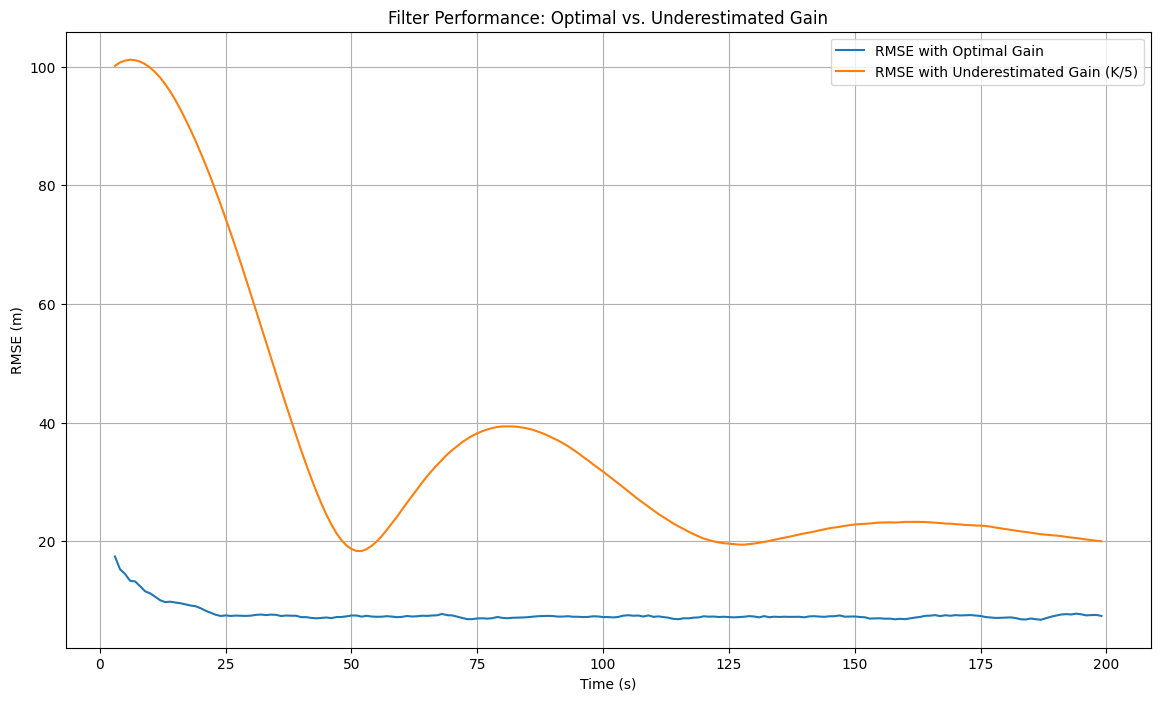

In [46]:
X0_0_far = np.array([[100.0], [5.0]])

# Condition 1: Optimal Filter
rmse_filt_opt, _, _ = monte_carlo_simulation(M, N, T, sigma_a, sigma_eta, X0_0_far, P0_0_orig, m)

# Find the steady-state gain from an optimal run
_, _, _, _, K_hist_opt, _ = run_kalman_filter(z, N, T, sigma_a_sq, sigma_eta_sq, X0_0_far, P0_0_orig, m)
K_steady_state = K_hist_opt[-1]
K_underestimated = K_steady_state / 5.0

# Condition 2: Filter with fixed, underestimated gain
rmse_filt_non_opt, _, _ = monte_carlo_simulation(M, N, T, sigma_a, sigma_eta, X0_0_far, P0_0_orig, m, fixed_K=K_underestimated)

plt.figure(figsize=(14, 8))
plt.plot(time_from_3, rmse_filt_opt, label='RMSE with Optimal Gain')
plt.plot(time_from_3, rmse_filt_non_opt, label='RMSE with Underestimated Gain (K/5)')
plt.title('Filter Performance: Optimal vs. Underestimated Gain')
plt.xlabel('Time (s)')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)
plt.show()